<a href="https://colab.research.google.com/github/madhulathachavali/AIML/blob/main/ATAC_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing scATACseq data

The data used in this analysis is Adult Mouse Cortex Cells dataset from 10X Genomics.

Background Information: Single Cell ATAC Dataset by Cell Ranger ATAC 2.1.0
Adult mouse cortex was obtained by 10x Genomics from BrainBits, LLC (PN C57ACX).
PeakVI is used for analyzing scATACseq data.

Data Analysis Outline

1. Read and set-up data

2. Train the model

3. Accessing and visualizing the latent space

4. Differential accessibility

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

     |████████████████████████████████| 235 kB 14.5 MB/s 
     |████████████████████████████████| 51 kB 5.2 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


Global seed set to 0


In [2]:
# Download the data from 10X Genomics
!wget https://cf.10xgenomics.com/samples/cell-atac/2.1.0/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.tar.gz
!tar -xvf 8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.tar.gz

--2022-07-28 00:12:44--  https://cf.10xgenomics.com/samples/cell-atac/2.1.0/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217625405 (208M) [application/x-tar]
Saving to: ‘8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.tar.gz’

8k_mouse_cortex_ATA 100%[===================>] 207.54M  15.8MB/s    in 10s     

2022-07-28 00:12:56 (20.0 MB/s) - ‘8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.tar.gz’ saved [217625405/217625405]

filtered_peak_bc_matrix/
filtered_peak_bc_matrix/barcodes.tsv
filtered_peak_bc_matrix/matrix.mtx
filtered_peak_bc_matrix/peaks.bed


In [4]:
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

scvi.settings.seed = 210

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 210


### Load the data 
PeakVI expects as input an AnnData object with a cell-by-region matrix

In [5]:
# Load other than 10X data: 1. read the count matrix into a sparse matrix  2. read cell and region annotations as pandas dataframes
#counts = scipy.io.mmread("filtered_peak_bc_matrix/matrix.mtx").T
#regions = pd.read_csv("filtered_peak_bc_matrix/peaks.bed", sep='\t', header=None, names=['chr','start','end'])
#cells = pd.read_csv("filtered_peak_bc_matrix/barcodes.tsv", header=None, names=['barcodes'])

# Initialize AnnData object
#adata = anndata.AnnData(X=counts, obs=cells, var=regions)

# read 10x data directly
adata = scvi.data.read_10x_atac("filtered_peak_bc_matrix")



/usr/local/lib/python3.7/dist-packages/scvi/data/_read.py:44: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(data.tocsr(), var=coords, obs=cell_annot)


In [6]:
# genes with less than 500 cells are filtered
print(adata.shape)
# compute the threshold: 5% of the cells
#min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=500)
print(adata.shape)

(7729, 176651)
(7729, 35820)


### Setup, train and save PEAKVI model

In [7]:
scvi.model.PEAKVI.setup_anndata(adata)

In [8]:
pvi = scvi.model.PEAKVI(adata)
pvi.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:386: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"


Epoch 169/500:  34%|███▍      | 169/500 [1:36:47<3:09:34, 34.36s/it, loss=1.87e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 12395.341. Signaling Trainer to stop.


In [9]:
# Save the model
pvi.save("trained_model", overwrite=True)

In [10]:
pvi = scvi.model.PEAKVI.load("trained_model", adata=adata)

INFO     File trained_model/model.pt already downloaded                                                            


### Visualizing and analyzing latent space

In [11]:
# extract the latent representation from the model, and save it back into our AnnData object
latent = pvi.get_latent_representation()
adata.obsm["X_PeakVI"] = latent

print(latent.shape)

(7729, 13)


In [16]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_PeakVI")
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (using lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added="cluster_pvi", resolution=0.2)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


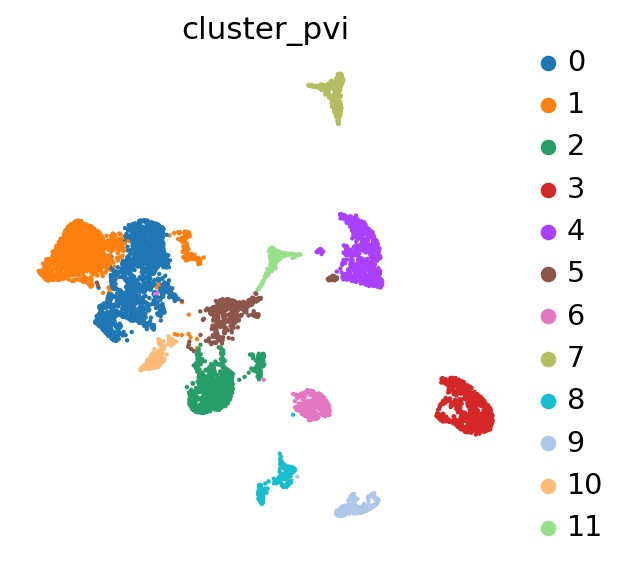

In [17]:
sc.pl.umap(adata, color='cluster_pvi')

### Differential Accessibility

WE are using PeakVI to identify regions that are differentially accessible. This can be done by either comparing one cluster against all others, or comparing two clusters to each other. 

#### * Marker regions identification
One cluster against all clusters gives us marker regions (using one-sided test).
The significant regions are preferentially accessible in our target cluster.


#### * Differentially accessible regions
Using two-sided test to find regions that are differentially accessible(regardless of direction)

In [24]:
# using indices to compare two clusters
## use boolean masks or integer indices for the `idx1` and `idx2` arguments
da_res21 = pvi.differential_accessibility(
    idx1 = adata.obs.cluster_pvi == '3',
    idx2 = adata.obs.cluster_pvi == '0',
    two_sided=True,
)
# using indices to compare a cluster against all other clusters
## if we don't provide idx2, it uses all other cells as the contrast
da_res22 = pvi.differential_accessibility(
    idx1 = np.where(adata.obs.cluster_pvi == '3'),
    two_sided=False,
)

da_res22.head()

DE...: 100%|██████████| 1/1 [00:34<00:00, 34.76s/it]


,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr5:140768302-140768746,1.0000,True,18.420681,-0.831699,-0.384829,0.942638,0.110938,0.427236,0.042407
chr17:44030565-44031453,0.9998,True,8.516943,-0.772346,-0.330389,0.861125,0.088778,0.364486,0.034097
chr9:14388754-14389662,0.9998,True,8.516943,-0.908037,-0.487377,0.961620,0.053583,0.510013,0.022636
chr10:122883722-122884609,0.9998,True,8.516943,-0.753737,-0.369978,0.955718,0.201981,0.457944,0.087966
chr5:140767864-140768223,0.9996,True,7.823621,-0.868566,-0.409355,0.943893,0.075327,0.440587,0.031232



The return value is a pandas DataFrame with the differential results and basic properties of the comparison:

`prob_da` in our case is the probability of cells from cluster 0 being more than 0.05 (the default minimal effect) more accessible than cells from the rest of the data.

`is_da_fdr` is a conservative classification (True/False) of whether a region is differential accessible. This is one way to threshold the results.

`bayes_factor` is a statistical significance score. It doesn't have a commonly acceptable threshold (e.g 0.05 for p-values), bu we demonstrate below that it's well calibrated to the effect size.

`effect_size` is the effect size, calculated as `est_prob1 - est_prob2`.

`emp_effect` is the empirical effect size, calculated as `emp_prob1 - emp_prob2`.

`est_prob{1,2}` are the estimated probabilities of accessibility in group1 and group2.

`emp_prob{1,2}` are the empirical probabilities of detection (how many cells in group X was the region detected in).

We can make sure the probability of DA is well calibrated, and look at the regions that are identified as differentially accessible:

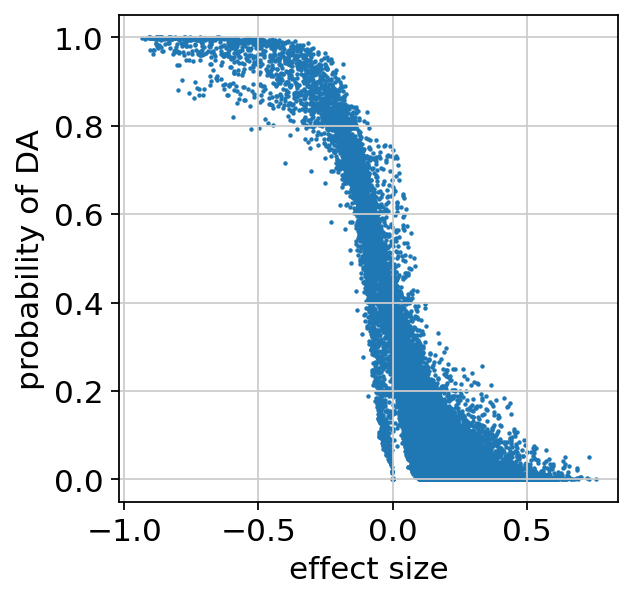

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr5:140768302-140768746,1.0000,True,18.420681,-0.831699,-0.384829,0.942638,0.110938,0.427236,0.042407
chr9:14388754-14389662,0.9998,True,8.516943,-0.908037,-0.487377,0.961620,0.053583,0.510013,0.022636
chr10:122883722-122884609,0.9998,True,8.516943,-0.753737,-0.369978,0.955718,0.201981,0.457944,0.087966
chr17:44030565-44031453,0.9998,True,8.516943,-0.772346,-0.330389,0.861125,0.088778,0.364486,0.034097
chr7:63986317-63987232,0.9996,True,7.823621,-0.873298,-0.513476,0.968357,0.095059,0.556742,0.043266
chr5:122693243-122694104,0.9996,True,7.823621,-0.868511,-0.467040,0.961547,0.093036,0.506008,0.038968
chr5:64702845-64703648,0.9996,True,7.823621,-0.647647,-0.263099,0.757254,0.109607,0.303071,0.039971
chr3:95904822-95905652,0.9996,True,7.823621,-0.864338,-0.443827,0.958912,0.094574,0.476636,0.032808
chr4:125644925-125645803,0.9996,True,7.823621,-0.859836,-0.430958,0.931046,0.071210,0.460614,0.029656
chr5:114102671-114103571,0.9996,True,7.823621,-0.906906,-0.460864,0.966595,0.059689,0.484646,0.023782


In [25]:
plt.scatter(da_res22.effect_size, da_res22.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res22.loc[da_res22.is_da_fdr].sort_values('prob_da', ascending=False).head(10)

Next steps would be to examine these regions using various different annotation and enrichment methods. 

For instance, chr5:140768302-140768746, one of the regions preferentially accessible in cluster 0.
